In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy.stats import boxcox
import statsmodels.api as sm
import seaborn as sns
from gplearn.genetic import SymbolicRegressor

In [2]:
df = pd.read_csv('forestfires[1].csv')
print(df)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


# Data Reprocessing

In [3]:
# df = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)
# print(df)

In [4]:
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
df['day_numeric'] = df['day'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7})

# Apply cyclical transformations
df['month_sin'] = np.sin(2 * np.pi * df['month_numeric'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_numeric'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_numeric'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_numeric'] / 7)

# Drop the original categorical columns if no longer needed
df = df.drop(columns=['month', 'day', 'month_numeric', 'day_numeric'])

#### Check for null values

In [5]:
print(df.isnull().sum())

X            0
Y            0
FFMC         0
DMC          0
DC           0
ISI          0
temp         0
RH           0
wind         0
rain         0
area         0
month_sin    0
month_cos    0
day_sin      0
day_cos      0
dtype: int64


no null values

#### Normalize Response Variable

In [6]:

df['area_log'] = np.log1p(df['area'])  
df['area'] = df['area_log']
df = df.drop(columns=['area_log'])

print(df)


     X  Y  FFMC    DMC     DC   ISI  temp  RH  wind  rain      area  \
0    7  5  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0  0.000000   
1    7  4  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0  0.000000   
2    7  4  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0  0.000000   
3    8  6  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2  0.000000   
4    8  6  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0  0.000000   
..  .. ..   ...    ...    ...   ...   ...  ..   ...   ...       ...   
512  4  3  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0  2.006871   
513  2  4  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  4.012592   
514  7  4  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  2.498152   
515  1  4  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0  0.000000   
516  6  3  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0  0.000000   

     month_sin     month_cos       day_sin   day_cos  
0     1.000000  6.123234e-17 -9.749279e-01 -0.222521  
1    -0.866025  5.000000e-01  9.74927

In [7]:
df['distance'] = np.sqrt(df['X']**2 + df['Y']**2)

df = df.drop(columns=['X', 'Y'])

<Axes: >

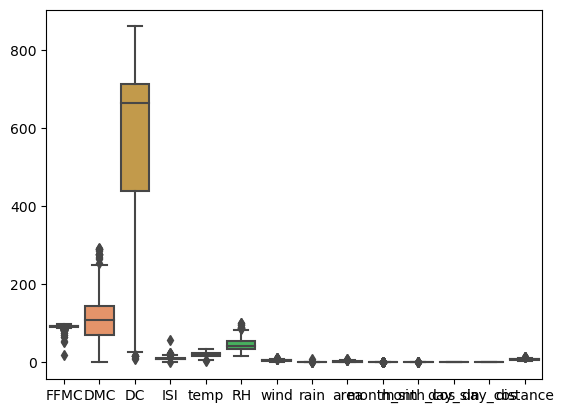

In [8]:
sns.boxplot(df)

#### Remove outliers

In [9]:
#  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Q1 = df[numeric_cols].quantile(0.25)
# Q3 = df[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = (df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)

# fire_data = df[~outliers.any(axis=1)] 

In [10]:
upper_limit = df['area'].quantile(0.95)
fire_data = df[df['area'] <= upper_limit]

In [11]:
area_column = fire_data.pop('area')
fire_data['area'] = area_column
print(fire_data)
fire_data.to_csv('Downloads/modified_fire_data', header = False, index=False)

     FFMC    DMC     DC   ISI  temp  RH  wind  rain  month_sin     month_cos  \
0    86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   1.000000  6.123234e-17   
1    90.6   35.4  669.1   6.7  18.0  33   0.9   0.0  -0.866025  5.000000e-01   
2    90.6   43.7  686.9   6.7  14.6  33   1.3   0.0  -0.866025  5.000000e-01   
3    91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   1.000000  6.123234e-17   
4    89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   1.000000  6.123234e-17   
..    ...    ...    ...   ...   ...  ..   ...   ...        ...           ...   
511  81.6   56.7  665.6   1.9  27.8  35   2.7   0.0  -0.866025 -5.000000e-01   
512  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0  -0.866025 -5.000000e-01   
514  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  -0.866025 -5.000000e-01   
515  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0  -0.866025 -5.000000e-01   
516  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0  -0.500000  8.660254e-01   

          day_sin   day_cos   distance 

C:\Users\smath\AppData\Local\Temp\ipykernel_12352\3361762442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_data['area'] = area_column


# Exploratory Data

#### Descriptive Statisitcs

In [12]:
print(fire_data.describe())

             FFMC         DMC          DC         ISI        temp          RH  \
count  491.000000  491.000000  491.000000  491.000000  491.000000  491.000000   
mean    90.616293  110.087169  545.747454    9.031772   18.735642   44.566191   
std      5.620445   63.981370  250.189819    4.606350    5.818638   16.471038   
min     18.700000    1.100000    7.900000    0.000000    2.200000   15.000000   
25%     90.200000   61.450000  432.050000    6.400000   15.400000   33.000000   
50%     91.600000  108.300000  661.300000    8.400000   19.200000   42.000000   
75%     92.900000  141.300000  714.100000   10.750000   22.650000   54.000000   
max     96.200000  291.300000  860.600000   56.100000   33.300000  100.000000   

             wind        rain   month_sin     month_cos       day_sin  \
count  491.000000  491.000000  491.000000  4.910000e+02  4.910000e+02   
mean     4.020570    0.022811   -0.531153 -2.181563e-01 -6.803060e-02   
std      1.801588    0.303666    0.710314  4.087868

#### Correlation Matrix

In [13]:
print(fire_data.corr())

               FFMC       DMC        DC       ISI      temp        RH  \
FFMC       1.000000  0.380021  0.331618  0.528665  0.434629 -0.291889   
DMC        0.380021  1.000000  0.684865  0.312442  0.465206  0.093719   
DC         0.331618  0.684865  1.000000  0.238303  0.495268 -0.028252   
ISI        0.528665  0.312442  0.238303  1.000000  0.403786 -0.122332   
temp       0.434629  0.465206  0.495268  0.403786  1.000000 -0.524777   
RH        -0.291889  0.093719 -0.028252 -0.122332 -0.524777  1.000000   
wind      -0.028784 -0.103661 -0.197347  0.096988 -0.237271  0.074530   
rain       0.057536  0.077761  0.037152  0.068578  0.073159  0.100153   
month_sin -0.327610 -0.623002 -0.953686 -0.293273 -0.535772  0.020309   
month_cos -0.294494 -0.430220 -0.118613 -0.381201 -0.495102 -0.035548   
day_sin   -0.012294 -0.052761 -0.003529 -0.003136 -0.017686 -0.016451   
day_cos   -0.144589 -0.051097 -0.057592 -0.109142 -0.069752  0.150282   
distance  -0.033664 -0.015355 -0.084553 -0.015117 -

#### boxplot

<Axes: >

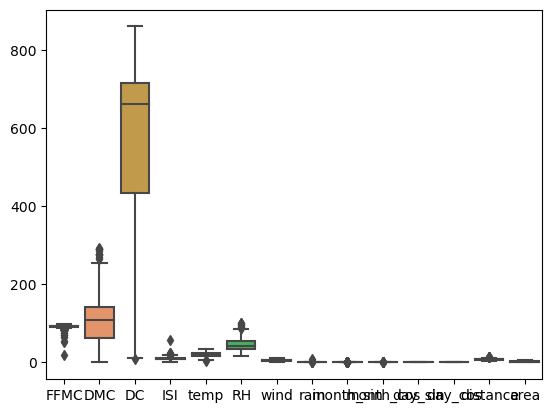

In [14]:
sns.boxplot(fire_data)

#### scatter plots against area

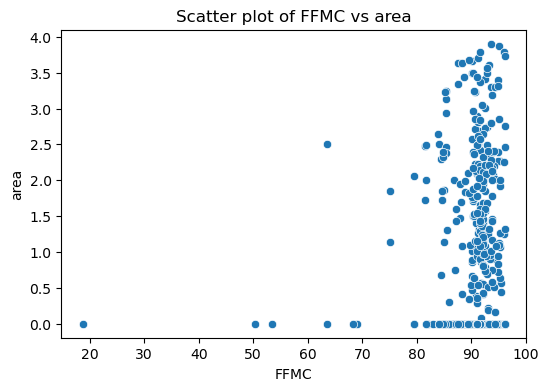

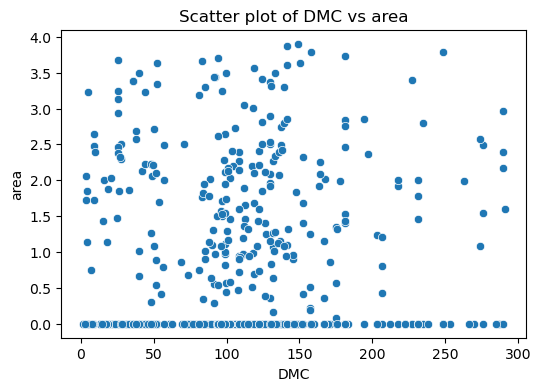

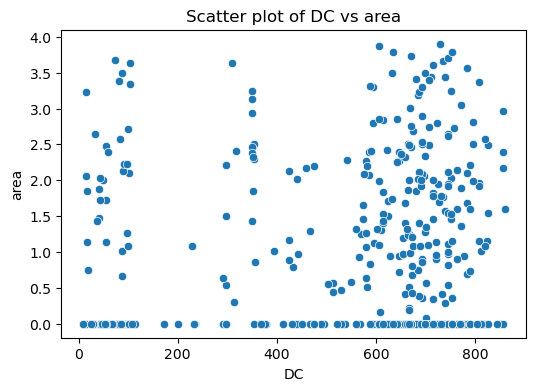

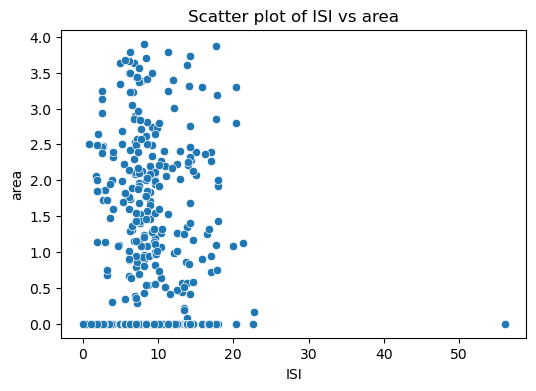

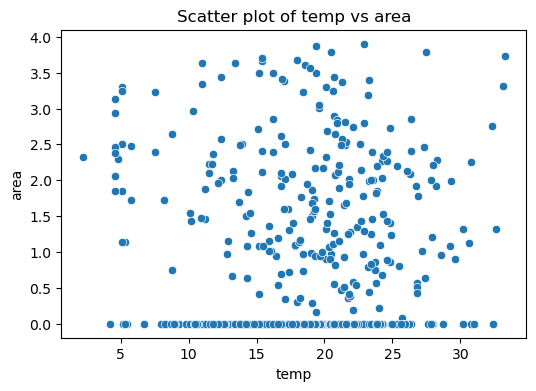

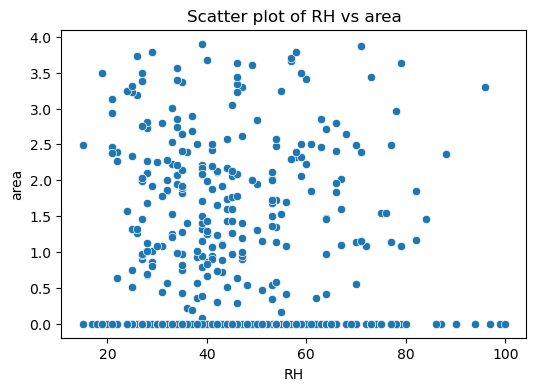

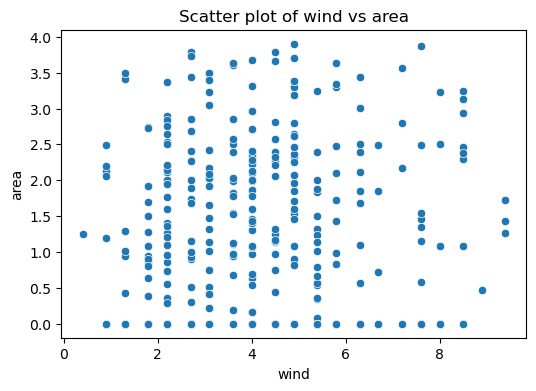

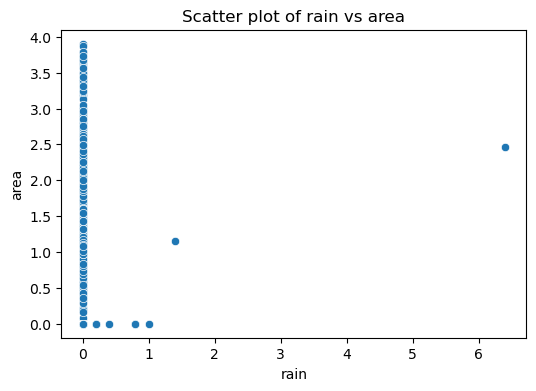

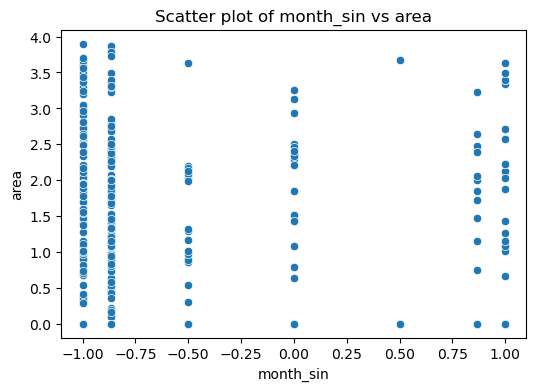

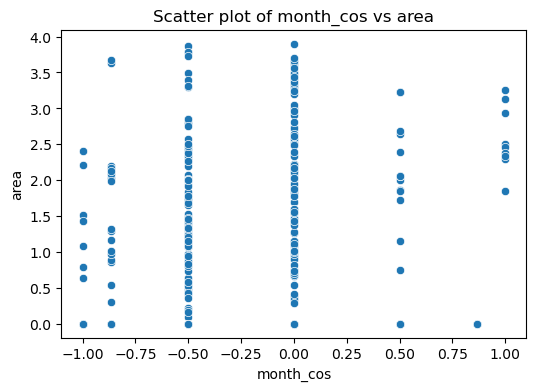

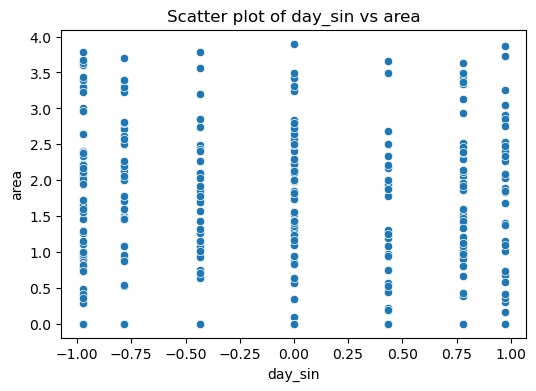

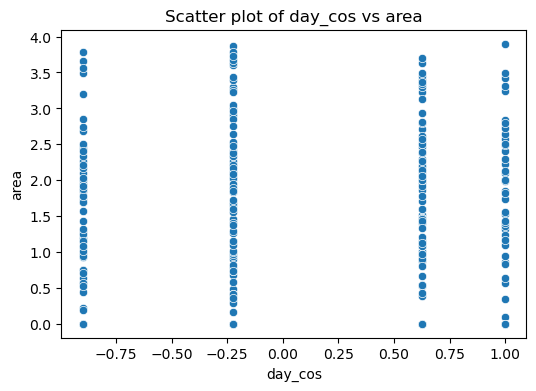

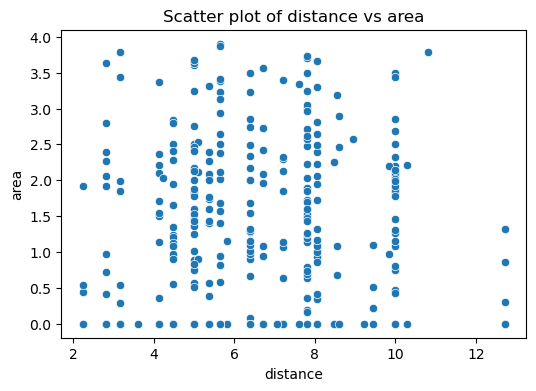

In [15]:
numeric_cols = fire_data.columns

for col in fire_data:
    if col != 'area':  
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=fire_data[col], y=fire_data['area'])
        plt.title(f'Scatter plot of {col} vs area')
        plt.xlabel(col)
        plt.ylabel('area')
        plt.show()


#### histogram for categorical variables

#### Splitting data into testing and data

In [16]:
X = fire_data.drop(columns=['area']) 
y = fire_data['area'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

#### Forward Selection

In [17]:
import statsmodels.api as sm

def forward_selection(X_train, y_train):
    initial_features = []
    remaining_features = list(X_train.columns)
    best_features = []
    best_r2 = -float('inf')
    
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features_to_test = initial_features + [candidate]
            X_train_sm = sm.add_constant(X_train[features_to_test])  
            model = sm.OLS(y_train, X_train_sm).fit()
            scores_with_candidates.append((model.rsquared, candidate))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score > best_r2:
            best_r2 = best_new_score
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_features = initial_features.copy()
        else:
            break

    return best_features

best_forward_features = forward_selection(X_train, y_train)
print(f"Best Forward Selected Features: {best_forward_features}")

Best Forward Selected Features: ['month_cos', 'wind', 'DMC', 'rain', 'FFMC', 'ISI', 'distance', 'RH', 'day_cos', 'month_sin', 'temp', 'DC', 'day_sin']


#### Backward eliminatioin

In [18]:
def backward_elimination(X_train, y_train):
    features = list(X_train.columns)
    while len(features) > 0:
        X_train_sm = sm.add_constant(X_train[features])  
        model = sm.OLS(y_train, X_train_sm).fit()
        p_values = model.pvalues[1:] 
        
        worst_p_value = p_values.max()
        if worst_p_value > 0.05:  
            worst_feature = p_values.idxmax() 
            features.remove(worst_feature)
        else:
            break

    return features

best_backward_features = backward_elimination(X_train, y_train)
print(f"Best Backward Selected Features: {best_backward_features}")


Best Backward Selected Features: ['month_cos']


#### Stepwise Selection

In [19]:
def stepwise_selection(X_train, y_train):
    initial_features = []
    remaining_features = list(X_train.columns)
    best_features = []
    best_r2 = -float('inf')
    
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features_to_test = initial_features + [candidate]
            X_train_sm = sm.add_constant(X_train[features_to_test])
            model = sm.OLS(y_train, X_train_sm).fit()
            scores_with_candidates.append((model.rsquared, candidate))
        
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score > best_r2:
            best_r2 = best_new_score
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_features = initial_features.copy()
        else:
            break

        while len(initial_features) > 1:
            X_train_sm = sm.add_constant(X_train[initial_features])
            model = sm.OLS(y_train, X_train_sm).fit()
            p_values = model.pvalues[1:] 
            worst_p_value = p_values.max()
            
            if worst_p_value > 0.05: 
                worst_feature = p_values.idxmax()
                initial_features.remove(worst_feature)
            else:
                break

    return best_features

best_stepwise_features = stepwise_selection(X_train, y_train)
print(f"Best Stepwise Selected Features: {best_stepwise_features}")


Best Stepwise Selected Features: ['month_cos', 'wind']


# Linear Regression

## Quality of Fit

#### In-sample

In [20]:
X_all = fire_data.drop('area', axis=1)  
y_all = fire_data['area']  

model = LinearRegression()
model.fit(X_all, y_all)

y_all_pred = model.predict(X_all)

mse_all = mean_squared_error(y_all, y_all_pred)
r2_all = r2_score(y_all, y_all_pred)

print(f"In-sample Mean Squared Error (MSE): {mse_all}")
print(f"In-sample R-squared (R²): {r2_all}")


In-sample Mean Squared Error (MSE): 1.2485054836105725
In-sample R-squared (R²): 0.03376026932623111


#### Validation using features from backward selection

In [21]:

X_train_selected = X_train[best_forward_features]  
X_test_selected = X_test[best_forward_features]

model = LinearRegression()

model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f"In-sample Training Mean Squared Error (MSE): {mse_train}")
print(f"In-sample Training R-squared (R²): {r2_train}")

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"Test Mean Squared Error (MSE): {mse_test}")
print(f"Test R-squared (R²): {r2_test}")

In-sample Training Mean Squared Error (MSE): 1.2444751463358408
In-sample Training R-squared (R²): 0.03181499718053027
Test Mean Squared Error (MSE): 1.2961665558786637
Test R-squared (R²): 0.016602017812565872


#### Plots for Validation sets

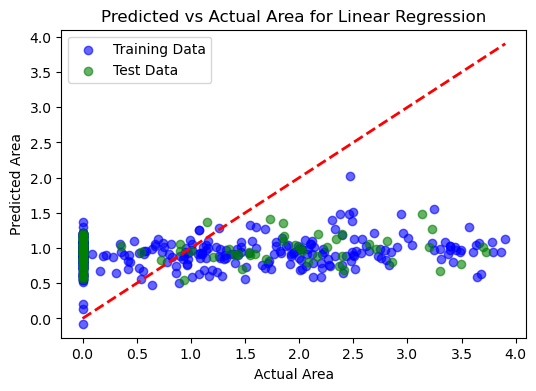

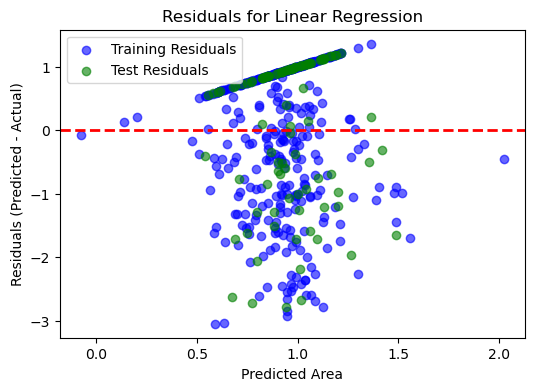

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot: Predictions vs Actual Values (Training)
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training Data')
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Test Data')
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Predicted vs Actual Area for Linear Regression')
plt.legend()
plt.show()

# Residual Plot: Errors (Training and Test)
plt.figure(figsize=(6, 4))
plt.scatter(y_train_pred, y_train_pred - y_train, alpha=0.6, color='blue', label='Training Residuals')
plt.scatter(y_test_pred, y_test_pred - y_test, alpha=0.6, color='green', label='Test Residuals')
plt.axhline(0, color='red', lw=2, linestyle='--')
plt.xlabel('Predicted Area')
plt.ylabel('Residuals (Predicted - Actual)')
plt.title('Residuals for Linear Regression')
plt.legend()
plt.show()

#### Cross-validation

In [23]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=KFold(n_splits=5), scoring='r2')

print(f"Cross-Validation R² scores: {scores}")
print(f"Mean R² score: {np.mean(scores)}")

Cross-Validation R² scores: [ 0.         -0.14073333 -0.64431418 -0.10233872 -1.34279614]
Mean R² score: -0.4460364750146


## Ridge Regression

#### In-sample

In [24]:
X_all = fire_data.drop('area', axis=1) 
y_all = fire_data['area']
ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_all, y_all)

y_all_pred = ridge_model.predict(X_all)

mse_all = mean_squared_error(y_all, y_all_pred)
r2_all = r2_score(y_all, y_all_pred)

print(f"In-sample Ridge MSE on the whole dataset: {mse_all}")
print(f"In-sample Ridge R-squared (R²) on the whole dataset: {r2_all}")


In-sample Ridge MSE on the whole dataset: 1.2485153404614937
In-sample Ridge R-squared (R²) on the whole dataset: 0.033752640940850065


#### Validation using all features

In [25]:
ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(X_train, y_train)

ry_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"In-sample Ridge Training MSE: {mse_train}")
print(f"In-sample Ridge Training R²: {r2_train}")
print(f"In-sample Ridge Test MSE: {mse_test}")
print(f"In-sample Ridge Test R²: {r2_test}")

In-sample Ridge Training MSE: 1.2444751463358408
In-sample Ridge Training R²: 0.03181499718053027
In-sample Ridge Test MSE: 1.2958619511136982
In-sample Ridge Test R²: 0.016833120605546537


#### Feature Selection

In [64]:
ridge_model = Ridge(alpha=1.0)

# Perform forward feature selection on the unscaled data
forward_selector = SequentialFeatureSelector(ridge_model, n_features_to_select='auto', direction='forward', scoring='r2', cv=5)
forward_selector.fit(X_train, y_train)

# Get selected features and fit the model
selected_features_forward = X_train.columns[forward_selector.get_support()]
X_train_forward = X_train[selected_features_forward]
X_test_forward = X_test[selected_features_forward]

# Fit the Ridge regression model on the selected features
ridge_model.fit(X_train_forward, y_train)

# Make predictions
y_train_pred = ridge_model.predict(X_train_forward)
y_test_pred = ridge_model.predict(X_test_forward)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Forward Selection Ridge Training MSE: {mse_train}")
print(f"Forward Selection Ridge Training R²: {r2_train}")
print(f"Forward Selection Ridge Test MSE: {mse_test}")
print(f"Forward Selection Ridge Test R²: {r2_test}")
print(f"Selected Features: {list(selected_features_forward)}")

# Perform backward feature selection on the unscaled data
backward_selector = SequentialFeatureSelector(ridge_model, n_features_to_select='auto', direction='backward', scoring='r2', cv=5)
backward_selector.fit(X_train, y_train)

# Get selected features and fit the model
selected_features_backward = X_train.columns[backward_selector.get_support()]
X_train_backward = X_train[selected_features_backward]
X_test_backward = X_test[selected_features_backward]

# Fit the Ridge regression model on the selected features
ridge_model.fit(X_train_backward, y_train)

# Make predictions
y_train_pred = ridge_model.predict(X_train_backward)
y_test_pred = ridge_model.predict(X_test_backward)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Backward Selection Ridge Training MSE: {mse_train}")
print(f"Backward Selection Ridge Training R²: {r2_train}")
print(f"Backward Selection Ridge Test MSE: {mse_test}")
print(f"Backward Selection Ridge Test R²: {r2_test}")
print(f"Selected Features: {list(selected_features_backward)}")


from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize stepwise selection
stepwise_selector = SFS(ridge_model, 
                        k_features='best', 
                        forward=True, 
                        floating=True, 
                        scoring='r2', 
                        cv=5)

# Fit stepwise selection on the unscaled data
stepwise_selector.fit(X_train, y_train)

# Get selected features and fit the model
selected_features_stepwise = X_train.columns[list(stepwise_selector.k_feature_idx_)]
X_train_stepwise = X_train[selected_features_stepwise]
X_test_stepwise = X_test[selected_features_stepwise]

# Fit the Ridge regression model on the selected features
ridge_model.fit(X_train_stepwise, y_train)

# Make predictions
y_train_pred = ridge_model.predict(X_train_stepwise)
y_test_pred = ridge_model.predict(X_test_stepwise)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Stepwise Selection Ridge Training MSE: {mse_train}")
print(f"Stepwise Selection Ridge Training R²: {r2_train}")
print(f"Stepwise Selection Ridge Test MSE: {mse_test}")
print(f"Stepwise Selection Ridge Test R²: {r2_test}")
print(f"Selected Features: {list(selected_features_stepwise)}")


Forward Selection Ridge Training MSE: 0.8055615003090485
Forward Selection Ridge Training R²: 0.1060524694439976
Forward Selection Ridge Test MSE: 0.8700400521781289
Forward Selection Ridge Test R²: -0.12678190225451158
Selected Features: ['DMC', 'temp', 'rain', 'month_sin', 'month_cos', 'distance']
Backward Selection Ridge Training MSE: 0.8055474676709726
Backward Selection Ridge Training R²: 0.10606804174003004
Backward Selection Ridge Test MSE: 0.8700265621562367
Backward Selection Ridge Test R²: -0.12676443143521898
Selected Features: ['DMC', 'DC', 'temp', 'rain', 'month_sin', 'month_cos', 'distance']
Stepwise Selection Ridge Training MSE: 0.8271083955110904
Stepwise Selection Ridge Training R²: 0.08214145364989056
Stepwise Selection Ridge Test MSE: 0.8391080227708222
Stepwise Selection Ridge Test R²: -0.0867220787453502
Selected Features: ['DMC', 'month_cos']


#### Plots for Validation Sets

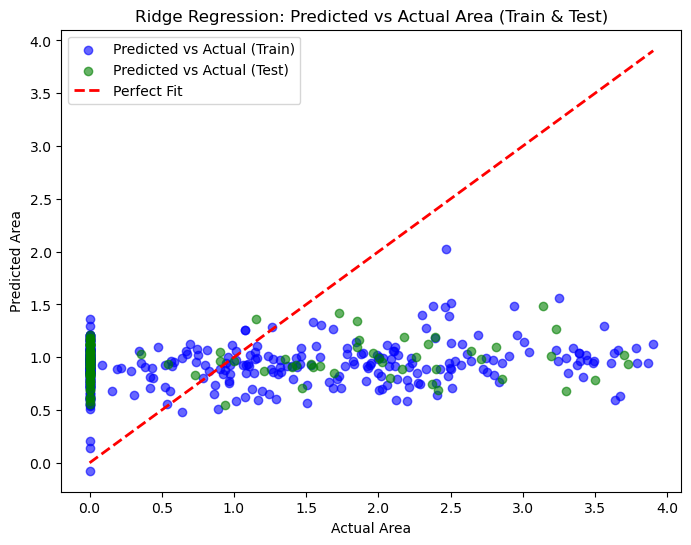

In [26]:
plt.figure(figsize=(8, 6))

# Training data plot
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Predicted vs Actual (Train)')

# Test data plot
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Predicted vs Actual (Test)')

plt.plot([min(min(y_train), min(y_test)), max(max(y_train), max(y_test))],
         [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))],
         color='red', lw=2, linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Ridge Regression: Predicted vs Actual Area (Train & Test)')
plt.legend()

plt.show()

#### Cross-validation

In [27]:
X_all = fire_data.drop('area', axis=1)  
y_all = fire_data['area']  

ridge_model = Ridge(alpha=1.0)

r2_scorer = make_scorer(r2_score)

cv_r2_scores = cross_val_score(ridge_model, X_all, y_all, cv=5, scoring=r2_scorer)

print(f"Cross-Validation R-squared (R²) for each fold: {cv_r2_scores}")
print(f"Mean Cross-Validation R-squared (R²): {cv_r2_scores.mean()}")
print(f"Standard Deviation of CV R-squared (R²): {cv_r2_scores.std()}")


Cross-Validation R-squared (R²) for each fold: [ 0.         -0.13633862 -0.63544434 -0.10057379 -0.66926543]
Mean Cross-Validation R-squared (R²): -0.30832443566696516
Standard Deviation of CV R-squared (R²): 0.2846363455978724


# Lasso Regression

#### In-sample

In [28]:
X_all = fire_data.drop('area', axis=1)  # Use all features except the target column
y_all = fire_data['area']  # The target column

lasso_model = Lasso(alpha=0.1)

lasso_model.fit(X_all, y_all)

y_all_pred_lasso = lasso_model.predict(X_all)

mse_all_lasso = mean_squared_error(y_all, y_all_pred_lasso)
r2_all_lasso = r2_score(y_all, y_all_pred_lasso)

print(f"In-sample Lasso MSE: {mse_all_lasso}")
print(f"In-sample Lasso R-squared (R²): {r2_all_lasso}")


In-sample Lasso MSE: 1.2705435801797464
In-sample Lasso R-squared (R²): 0.016704609761180267


#### Validation using forward selection features

In [29]:
X_train_selected = X_train[best_forward_features]
X_test_selected = X_test[best_forward_features]

lasso_model = Lasso(alpha=0.1)

lasso_model.fit(X_train_selected, y_train)

y_train_pred_lasso = lasso_model.predict(X_train_selected)
y_test_pred_lasso = lasso_model.predict(X_test_selected)

mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)

mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"Lasso Training MSE: {mse_train_lasso}")
print(f"Lasso Training R²: {r2_train_lasso}")
print(f"Lasso Test MSE: {mse_test_lasso}")
print(f"Lasso Test R²: {r2_test_lasso}")


Lasso Training MSE: 1.267506333137578
Lasso Training R²: 0.013897042190243902
Lasso Test MSE: 1.3056435633276184
Lasso Test R²: 0.009411838463925237


#### Plot for Validation set

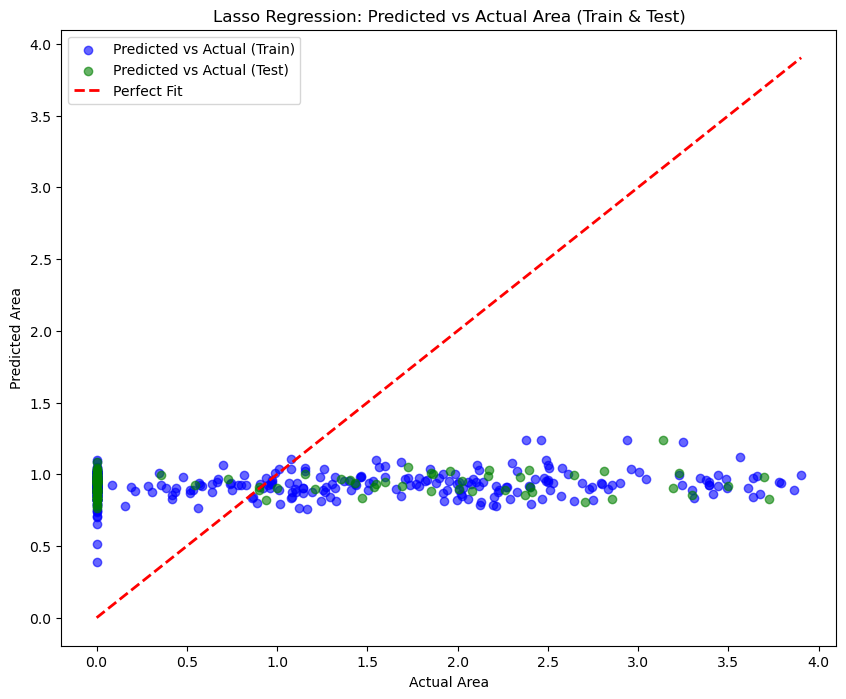

In [30]:

plt.figure(figsize=(10, 8))

plt.scatter(y_train, y_train_pred_lasso, alpha=0.6, color='blue', label='Predicted vs Actual (Train)')
plt.scatter(y_test, y_test_pred_lasso, alpha=0.6, color='green', label='Predicted vs Actual (Test)')

plt.plot([min(min(y_train), min(y_test)), max(max(y_train), max(y_test))],
         [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))],
         color='red', lw=2, linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Lasso Regression: Predicted vs Actual Area (Train & Test)')
plt.legend()

plt.show()


#### Cross-validation

In [31]:
from sklearn.metrics import make_scorer
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scorer = make_scorer(mean_squared_error)

mse_cv_scores = cross_val_score(lasso_model, X_train_selected, y_train, cv=kf, scoring=mse_scorer)

r2_cv_scores = cross_val_score(lasso_model, X_train_selected, y_train, cv=kf, scoring='r2')

print(f"Lasso Cross-Validation MSE Scores: {mse_cv_scores}")
print(f"Mean Cross-Validation MSE: {mse_cv_scores.mean()}")
print(f"Lasso Cross-Validation R² Scores: {r2_cv_scores}")
print(f"Mean Cross-Validation R²: {r2_cv_scores.mean()}")


Lasso Cross-Validation MSE Scores: [1.4125285  1.53782405 1.15803997 1.34701585 1.19879227]
Mean Cross-Validation MSE: 1.3308401277238402
Lasso Cross-Validation R² Scores: [-0.08700199 -0.07647907 -0.04512078 -0.0304344  -0.00642342]
Mean Cross-Validation R²: -0.0490919320593167


# Transformed Regression

#### In-sample

In [60]:
X_all = fire_data.drop(columns=['area'])  # Drop the target column
y_all = fire_data['area']  # Target variable

# Apply log1p transformation to the target variable (handles zeros by shifting)
y_all_log = np.log1p(y_all)  # Equivalent to log(y + 1)

# Scale the features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X_all_scaled, y_all_log)

# Make predictions on the transformed data
y_all_pred_log = model.predict(X_all_scaled)

# Reverse the log1p transformation to return predictions to the original scale
y_all_pred = np.expm1(y_all_pred_log)  # Reverse log1p transformation

# Calculate MSE and R² for the entire dataset
mse_all = mean_squared_error(y_all, y_all_pred)
r2_all = r2_score(y_all, y_all_pred)

# Print in-sample results
print(f"In-sample Log-Transformed Regression MSE: {mse_all}")
print(f"In-sample Log-Transformed Regression R²: {r2_all}")

In-sample Log-Transformed Regression MSE: 0.8250743406031684
In-sample Log-Transformed Regression R²: 0.06077131564276317


#### Validation using boxcox transformation

In [56]:
y_train_shifted = y_train + 1
y_test_shifted = y_test + 1

y_train_boxcox, fitted_lambda = boxcox(y_train_shifted)
y_test_boxcox = boxcox(y_test_shifted, lmbda=fitted_lambda)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train_boxcox)

# Make predictions on the transformed target variable
y_train_pred_boxcox = model.predict(X_train_scaled)
y_test_pred_boxcox = model.predict(X_test_scaled)

# Reverse the Box-Cox transformation for predictions (inverse transformation)
# We also need to subtract the shift (1) that was added to the target variable
y_train_pred_shifted = np.power(y_train_pred_boxcox * fitted_lambda + 1, 1/fitted_lambda) - 1
y_test_pred_shifted = np.power(y_test_pred_boxcox * fitted_lambda + 1, 1/fitted_lambda) - 1

# Calculate MSE and R² for training and test sets
mse_train = mean_squared_error(y_train, y_train_pred_shifted)
r2_train = r2_score(y_train, y_train_pred_shifted)

mse_test = mean_squared_error(y_test, y_test_pred_shifted)
r2_test = r2_score(y_test, y_test_pred_shifted)

print(f"Transformed (Box-Cox with Shift) Regression Training MSE: {mse_train}")
print(f"Transformed (Box-Cox with Shift) Regression Training R²: {r2_train}")
print(f"Transformed (Box-Cox with Shift) Regression Test MSE: {mse_test}")
print(f"Transformed (Box-Cox with Shift) Regression Test R²: {r2_test}")


Transformed (Box-Cox with Shift) Regression Training MSE: 0.7951813802518235
Transformed (Box-Cox with Shift) Regression Training R²: 0.11757149398584976
Transformed (Box-Cox with Shift) Regression Test MSE: 0.9155894548370328
Transformed (Box-Cox with Shift) Regression Test R²: -0.1857725687716072


#### Validation using Log transformation

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Apply log1p transformation (handles zeros by shifting)
y_train_log = np.log1p(y_train)  # Equivalent to log(y + 1)
y_test_log = np.log1p(y_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)

# Make predictions on the transformed data
y_train_pred_log = model.predict(X_train_scaled)
y_test_pred_log = model.predict(X_test_scaled)

# Reverse the log1p transformation to return to the original scale
y_train_pred = np.expm1(y_train_pred_log)  # Reverse log1p
y_test_pred = np.expm1(y_test_pred_log)

# Calculate MSE and R² for training and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Log-Transformed Regression Training MSE: {mse_train}")
print(f"Log-Transformed Regression Training R²: {r2_train}")
print(f"Log-Transformed Regression Test MSE: {mse_test}")
print(f"Log-Transformed Regression Test R²: {r2_test}")


Log-Transformed Regression Training MSE: 1.3220828999823033
Log-Transformed Regression Training R²: -0.02856279614402646
Log-Transformed Regression Test MSE: 1.337394391508632
Log-Transformed Regression Test R²: -0.014677427089468287


#### Plot for log validation set

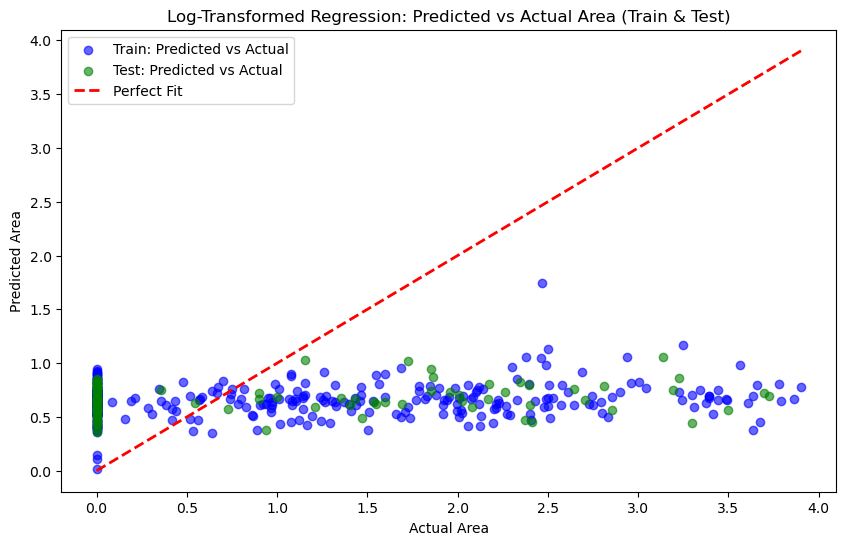

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Train: Predicted vs Actual')
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6, label='Test: Predicted vs Actual')
max_val = max(max(y_train), max(y_test))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Log-Transformed Regression: Predicted vs Actual Area (Train & Test)')
plt.legend()

plt.show()


#### Cross-validation

In [62]:

# Custom MSE scorer to handle log transformation
def custom_mse_scorer(y_true, y_pred_log):
    y_pred = np.expm1(y_pred_log)  # Reverse log1p transformation
    return mean_squared_error(y_true, y_pred)

# Custom R² scorer to handle log transformation
def custom_r2_scorer(y_true, y_pred_log):
    y_pred = np.expm1(y_pred_log)  # Reverse log1p transformation
    return r2_score(y_true, y_pred)

# Create scorers for MSE and R²
mse_scorer = make_scorer(custom_mse_scorer, greater_is_better=False)
r2_scorer = make_scorer(custom_r2_scorer)

# Define KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize linear regression model
model = LinearRegression()

# Scale the features before cross-validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform cross-validation for MSE
mse_scores = cross_val_score(model, X_train_scaled, np.log1p(y_train), scoring=mse_scorer, cv=kf)

# Perform cross-validation for R²
r2_scores = cross_val_score(model, X_train_scaled, np.log1p(y_train), scoring=r2_scorer, cv=kf)

# Since cross_val_score returns negative MSE (because scoring metric prefers larger values),
# we convert it back to positive by taking the absolute value.
mse_scores = -mse_scores

# Print Cross-Validation results
print(f"Log-Transformed Regression Cross-Validation MSE Scores: {mse_scores}")
print(f"Mean Cross-Validation MSE: {np.mean(mse_scores)}")
print(f"Standard Deviation of Cross-Validation MSE: {np.std(mse_scores)}")

print(f"Log-Transformed Regression Cross-Validation R² Scores: {r2_scores}")
print(f"Mean Cross-Validation R²: {np.mean(r2_scores)}")
print(f"Standard Deviation of Cross-Validation R²: {np.std(r2_scores)}")

Log-Transformed Regression Cross-Validation MSE Scores: [1.07367039 0.77291304 0.59653056 0.79618109 0.74266956]
Mean Cross-Validation MSE: 0.7963929281624372
Standard Deviation of Cross-Validation MSE: 0.15509049173410783
Log-Transformed Regression Cross-Validation R² Scores: [-9.7018309  -6.59857742 -3.36819052 -5.04614237 -4.44773104]
Mean Cross-Validation R²: -5.832494446713019
Standard Deviation of Cross-Validation R²: 2.1985159000700825


#### Feature selection

In [63]:
model = LinearRegression()

# Perform forward feature selection on the unscaled data
forward_selector = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='r2', cv=5)
forward_selector.fit(X_train, np.log1p(y_train))

# Get selected features and fit the model
selected_features_forward = X_train.columns[forward_selector.get_support()]
X_train_forward = X_train[selected_features_forward]

# Fit the model on the selected features
model.fit(X_train_forward, np.log1p(y_train))
y_train_pred_log = model.predict(X_train_forward)
y_train_pred = np.expm1(y_train_pred_log)

# Calculate the R² score
r2_train_forward = r2_score(y_train, y_train_pred)

print(f"Forward Selection Selected Features: {list(selected_features_forward)}")
print(f"Forward Selection R²: {r2_train_forward}")


# Perform backward feature selection on the unscaled data
backward_selector = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='r2', cv=5)
backward_selector.fit(X_train, np.log1p(y_train))

# Get selected features and fit the model
selected_features_backward = X_train.columns[backward_selector.get_support()]
X_train_backward = X_train[selected_features_backward]

# Fit the model on the selected features
model.fit(X_train_backward, np.log1p(y_train))
y_train_pred_log = model.predict(X_train_backward)
y_train_pred = np.expm1(y_train_pred_log)

# Calculate the R² score
r2_train_backward = r2_score(y_train, y_train_pred)

print(f"Backward Selection Selected Features: {list(selected_features_backward)}")
print(f"Backward Selection R²: {r2_train_backward}")


from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize stepwise selection
stepwise_selector = SFS(model, 
                        k_features='best', 
                        forward=True, 
                        floating=True, 
                        scoring='r2', 
                        cv=5)

# Fit stepwise selection on the unscaled data
stepwise_selector.fit(X_train, np.log1p(y_train))

# Get selected features and fit the model
selected_features_stepwise = X_train.columns[list(stepwise_selector.k_feature_idx_)]
X_train_stepwise = X_train[selected_features_stepwise]

# Fit the model on the selected features
model.fit(X_train_stepwise, np.log1p(y_train))
y_train_pred_log = model.predict(X_train_stepwise)
y_train_pred = np.expm1(y_train_pred_log)

# Calculate the R² score
r2_train_stepwise = r2_score(y_train, y_train_pred)

print(f"Stepwise Selection Selected Features: {list(selected_features_stepwise)}")
print(f"Stepwise Selection R²: {r2_train_stepwise}")


Forward Selection Selected Features: ['DMC', 'temp', 'rain', 'month_sin', 'month_cos', 'distance']
Forward Selection R²: 0.0802306633544233
Backward Selection Selected Features: ['DMC', 'DC', 'temp', 'rain', 'month_sin', 'month_cos', 'distance']
Backward Selection R²: 0.08002213116306145
Stepwise Selection Selected Features: ['DMC', 'temp', 'month_sin', 'month_cos']
Stepwise Selection R²: 0.07309182157469796


# Symbolic Regression

#### In-sample

In [37]:
X_all = fire_data.drop(columns=['area']) 
y_all = fire_data['area'] 
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)  
symbolic_regressor = SymbolicRegressor(
    population_size=1000,     
    generations=20,            
    tournament_size=20,       
    stopping_criteria=0.01,   
    p_crossover=0.7,          
    p_subtree_mutation=0.1,   
    p_hoist_mutation=0.05,    
    p_point_mutation=0.1,     
    max_samples=0.9,          
    verbose=1,                
    parsimony_coefficient=0.01, 
    random_state=42,           
    n_jobs=-1                 
)

symbolic_regressor.fit(X_all_scaled, y_all)

y_all_pred = symbolic_regressor.predict(X_all_scaled)

mse_all = mean_squared_error(y_all, y_all_pred)
r2_all = r2_score(y_all, y_all_pred)

print(f"Symbolic Regression In-sample MSE on the whole dataset: {mse_all}")
print(f"Symbolic Regression In-sample R² on the whole dataset: {r2_all}")

print(f"Best equation: {symbolic_regressor._program}")


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.69           100994        3         0.888126          1.19467     34.17s
   1     4.44          1.60743        3         0.887268          1.20224     10.81s
   2     3.57          1.18735        5         0.856694          1.47191      9.97s
   3     3.10          1.29059        3         0.862723          1.41872      9.56s
   4     2.16          2.11407        1         0.852911           1.5323      8.57s
   5     1.43           1.0591        1         0.864908          1.40758      8.12s
   6     1.36          1.11617        3         0.874748          1.31267      7.51s
   7     1.38          1.17489        1         0.868545           1.3755      7.36s
   8     1.38          1.17129        1         0.860839          1.44347  

#### Validation

In [38]:
#pip install gplearn

In [39]:
X = fire_data.drop(columns=['area'])  # All features except 'area'
y = fire_data['area']  # The target variable

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

symbolic_regressor = SymbolicRegressor(
    population_size=1000,     
    generations=20,            
    tournament_size=20,       
    stopping_criteria=0.01,   
    p_crossover=0.7,          
    p_subtree_mutation=0.1,   
    p_hoist_mutation=0.05,    
    p_point_mutation=0.1,      
    max_samples=0.9,           
    verbose=1,                
    parsimony_coefficient=0.01, 
    random_state=42,           
    n_jobs=-1                 
)

symbolic_regressor.fit(X_train_scaled, y_train)

y_train_pred = symbolic_regressor.predict(X_train_scaled)
y_test_pred = symbolic_regressor.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Symbolic Regression Training MSE: {mse_train}")
print(f"Symbolic Regression Training R²: {r2_train}")
print(f"Symbolic Regression Test MSE: {mse_test}")
print(f"Symbolic Regression Test R²: {r2_test}")

print(f"Best equation: {symbolic_regressor._program}")


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.69          70777.9        3         0.902656          1.13034      3.53s
   1     4.51          1.79538        3         0.879569          1.33351      9.89s
   2     3.48           1.1981        1         0.863336          1.48447     10.01s
   3     2.77          1.25888        3         0.857555          1.52724      8.30s
   4     1.82          2.03595        1         0.855148          1.51972      8.75s
   5     1.37          1.04179        1         0.872293          1.40565      7.88s
   6     1.34          1.14202        1         0.853473          1.53445      7.21s
   7     1.35          1.15222        1         0.871824          1.36922      6.28s
   8     1.38           1.1967        1         0.870551          1.38417  

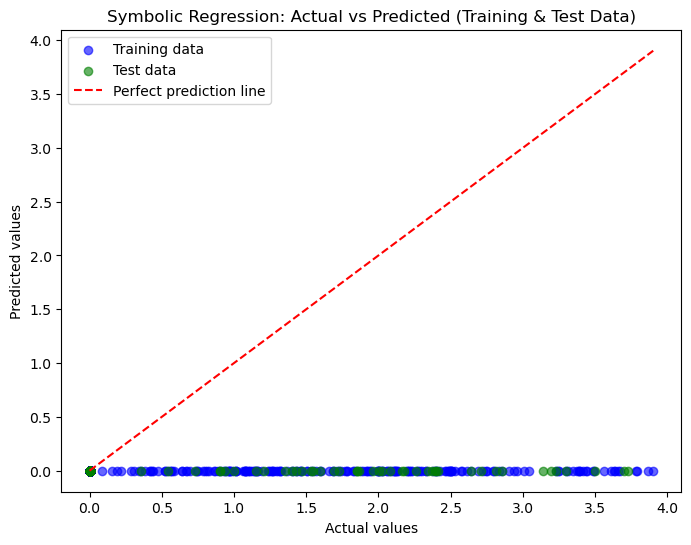

In [40]:
plt.figure(figsize=(8, 6))

plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Training data')
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6, label='Test data')
plt.plot([min(np.min(y_train), np.min(y_test)), max(np.max(y_train), np.max(y_test))], 
         [min(np.min(y_train), np.min(y_test)), max(np.max(y_train), np.max(y_test))], 
         color='red', linestyle='--', label='Perfect prediction line')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Symbolic Regression: Actual vs Predicted (Training & Test Data)')
plt.legend()

# Display the plot
plt.show()

#### Model with no zeros in area 

In [41]:
fire_data = fire_data[fire_data['area'] != 0]

# Split data into features and target
X = fire_data.drop(columns=['area'])
y = fire_data['area']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the SymbolicRegressor
symbolic_regressor = SymbolicRegressor(
    population_size=2000,  # Try increasing the population size
    generations=20,        # Increase the number of generations
    tournament_size=20,
    stopping_criteria=0.01,
    p_crossover=0.7,       # Increase crossover probability
    p_subtree_mutation=0.1, # Increase subtree mutation probability
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,   # Increase point mutation probability
    max_samples=1.0,        # Use the full sample set
    verbose=1,
    parsimony_coefficient=0.001, # Decrease to allow more complex equations
    random_state=42,
    n_jobs=-1
)

symbolic_regressor.fit(X_train_scaled, y_train)

# Predict using the trained model
y_train_pred = symbolic_regressor.predict(X_train_scaled)
y_test_pred = symbolic_regressor.predict(X_test_scaled)

# Calculate and print the MSE and R² metrics for both train and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Symbolic Regression Training MSE: {mse_train}")
print(f"Symbolic Regression Training R²: {r2_train}")
print(f"Symbolic Regression Test MSE: {mse_test}")
print(f"Symbolic Regression Test R²: {r2_test}")
print(f"Best equation: {symbolic_regressor._program}")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.24          6649.11       31          1.03318              N/A      5.82s
   1     6.36          2.76982        5          0.78434              N/A     16.90s
   2     8.25          25.1548        5          0.78434              N/A     17.42s
   3     5.56          2.01515        7         0.782392              N/A     19.92s
   4     5.69          3.53126        7         0.782392              N/A     15.87s
   5     4.77          1.54212        3         0.782852              N/A     15.00s
   6     3.62          1.26319        3         0.782852              N/A     14.86s
   7     3.22          1.15921        3         0.782852              N/A     12.49s
   8     3.24          1.80365        3         0.782852              N/A  

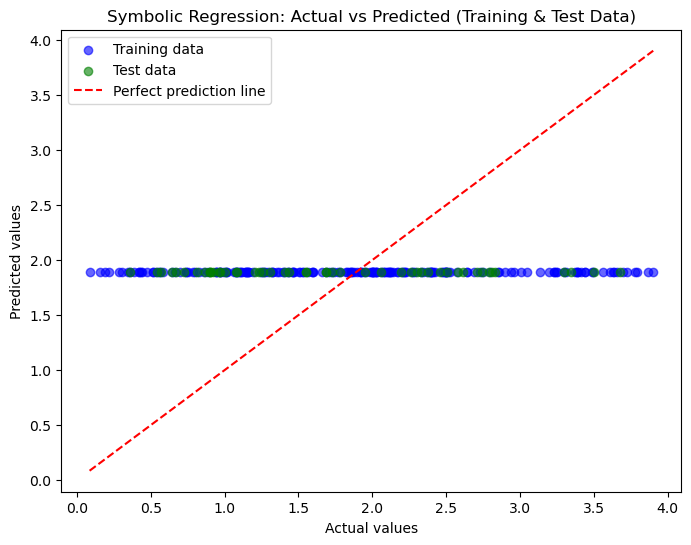

In [42]:
plt.figure(figsize=(8, 6))

plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Training data')
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6, label='Test data')
plt.plot([min(np.min(y_train), np.min(y_test)), max(np.max(y_train), np.max(y_test))], 
         [min(np.min(y_train), np.min(y_test)), max(np.max(y_train), np.max(y_test))], 
         color='red', linestyle='--', label='Perfect prediction line')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Symbolic Regression: Actual vs Predicted (Training & Test Data)')
plt.legend()

# Display the plot
plt.show()

#### Forward Selection

In [48]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear regression for the feature selection process
lr = LinearRegression()

# Forward selection
forward_selector = SequentialFeatureSelector(
    lr, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5
)

X_train_forward_selected = forward_selector.fit_transform(X_train_scaled, y_train)
X_test_forward_selected = forward_selector.transform(X_test_scaled)

# Refit symbolic regressor with selected features
symbolic_regressor.fit(X_train_forward_selected, y_train)

y_train_forward_pred = symbolic_regressor.predict(X_train_forward_selected)
y_test_forward_pred = symbolic_regressor.predict(X_test_forward_selected)

# Calculate performance metrics
mse_train_forward = mean_squared_error(y_train, y_train_forward_pred)
r2_train_forward = r2_score(y_train, y_train_forward_pred)
mse_test_forward = mean_squared_error(y_test, y_test_forward_pred)
r2_test_forward = r2_score(y_test, y_test_forward_pred)
selected_features_mask = forward_selector.get_support()
selected_features = X_train.columns[selected_features_mask]

print(f"Selected features: {list(selected_features)}")
print(f"Forward Selection Training MSE: {mse_train_forward}")
print(f"Forward Selection Training R²: {r2_train_forward}")
print(f"Forward Selection Test MSE: {mse_test_forward}")
print(f"Forward Selection Test R²: {r2_test_forward}")


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.97          193.613        5         0.785939          1.17833      4.99s
   1     5.79          2.59823        5         0.777737          0.82671      9.85s
   2     4.74            2.304        3         0.751998          1.14185      9.61s
   3     3.81          1.39648        5         0.757406          1.08941      9.29s
   4     3.35          1.69384        3         0.752985          1.13322      9.18s
   5     3.29          3.42368        3         0.753546          1.12831      9.86s
   6     3.19          1.34896        3         0.746794          1.18739      7.95s
   7     3.20          1.42964        3         0.761255          1.06086      6.96s
   8     3.45          71.9176        3         0.748106           1.1759  

#### Backward Selection

In [52]:
lr = LinearRegression()

# Perform backward selection on unscaled data
backward_selector = SequentialFeatureSelector(
    lr, n_features_to_select=5, direction='backward', scoring='neg_mean_squared_error', cv=5
)

# Select features on the unscaled data
X_train_backward_selected_unscaled = backward_selector.fit_transform(X_train, y_train)
X_test_backward_selected_unscaled = backward_selector.transform(X_test)

# Now scale the selected features
scaler = StandardScaler()
X_train_backward_selected_scaled = scaler.fit_transform(X_train_backward_selected_unscaled)
X_test_backward_selected_scaled = scaler.transform(X_test_backward_selected_unscaled)

# Refit symbolic regressor with selected and scaled features
symbolic_regressor.fit(X_train_backward_selected_scaled, y_train)

y_train_backward_pred = symbolic_regressor.predict(X_train_backward_selected_scaled)
y_test_backward_pred = symbolic_regressor.predict(X_test_backward_selected_scaled)

# Calculate performance metrics
mse_train_backward = mean_squared_error(y_train, y_train_backward_pred)
r2_train_backward = r2_score(y_train, y_train_backward_pred)
mse_test_backward = mean_squared_error(y_test, y_test_backward_pred)
r2_test_backward = r2_score(y_test, y_test_backward_pred)

# Get selected features' names
selected_features_mask = backward_selector.get_support()
selected_features = X_train.columns[selected_features_mask]

# Output results
print(f"Selected features: {list(selected_features)}")
print(f"Backward Elimination Training MSE: {mse_train_backward}")
print(f"Backward Elimination Training R²: {r2_train_backward}")
print(f"Backward Elimination Test MSE: {mse_test_backward}")
print(f"Backward Elimination Test R²: {r2_test_backward}")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.84          1761.66        3         0.825986         0.683856      5.77s
   1     7.61          3.25841       15         0.778436         0.854885      7.73s
   2     6.00           1.9243        7         0.761826          1.02498      9.68s
   3     4.53          1.57028        7         0.756789           1.0443      8.11s
   4     3.69          1.45693        5         0.749056          1.07158      7.33s
   5     3.66          3.58946        5         0.747754          1.08358      6.80s
   6     3.64          1.34979        5         0.743485           1.1207      5.82s
   7     3.36          1.29823        3         0.753482           1.0843      5.18s
   8     3.32          1.35153        3         0.740717          1.17709  

#### Stepwise Selection

In [45]:
#pip install mlxtend

In [55]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

lr = LinearRegression()

# Stepwise feature selection
sfs = SFS(
    lr, 
    k_features='best', 
    forward=True, 
    floating=True, 
    scoring='neg_mean_squared_error', 
    cv=5
)

# Fit stepwise selection on the unscaled data (if you want to retain feature names)
sfs.fit(X_train, y_train)

# Get the selected features' indices and names
selected_features_idx = sfs.k_feature_idx_  # Indices of selected features
selected_features = X_train.columns[list(selected_features_idx)]  # Names of selected features

# Now scale only the selected features
scaler = StandardScaler()
X_train_stepwise_selected = scaler.fit_transform(X_train[selected_features])
X_test_stepwise_selected = scaler.transform(X_test[selected_features])

# Refit symbolic regressor with selected and scaled features
symbolic_regressor.fit(X_train_stepwise_selected, y_train)

y_train_stepwise_pred = symbolic_regressor.predict(X_train_stepwise_selected)
y_test_stepwise_pred = symbolic_regressor.predict(X_test_stepwise_selected)

# Calculate performance metrics
mse_train_stepwise = mean_squared_error(y_train, y_train_stepwise_pred)
r2_train_stepwise = r2_score(y_train, y_train_stepwise_pred)
mse_test_stepwise = mean_squared_error(y_test, y_test_stepwise_pred)
r2_test_stepwise = r2_score(y_test, y_test_stepwise_pred)

# Print the selected features and performance metrics
print(f"Selected features: {list(selected_features)}")
print(f"Stepwise Selection Training MSE: {mse_train_stepwise}")
print(f"Stepwise Selection Training R²: {r2_train_stepwise}")
print(f"Stepwise Selection Test MSE: {mse_test_stepwise}")
print(f"Stepwise Selection Test R²: {r2_test_stepwise}")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    36.26          3541.92       15         0.774456         0.889717     28.95s
   1    10.15           3.4845       17         0.765779         0.967492      7.31s
   2     8.16          1.87637       15          0.75898          1.02513      9.07s
   3     5.64          1.44087        5         0.750664          1.11986      7.26s
   4     4.87          1.44252        5         0.753595          1.07225      6.95s
   5     3.83          1.41797        5          0.75572          1.03469      6.27s
   6     3.47          1.41176        3         0.755211          1.16243      5.89s
   7     3.27            1.403        5         0.756345          1.02922      5.85s
   8     3.26          1.27454        3         0.748527          1.13532  

#### Cross-Validation

In [47]:

X_scaled = scaler.fit_transform(X) 

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

symbolic_regressor = SymbolicRegressor(
    population_size=1000,      
    generations=20,            
    tournament_size=20,        
    stopping_criteria=0.01,    
    p_crossover=0.7,           
    p_subtree_mutation=0.1,    
    p_hoist_mutation=0.05,     
    p_point_mutation=0.1,      
    max_samples=0.9,           
    verbose=1,                 
    parsimony_coefficient=0.01,
    random_state=42,           
    n_jobs=-1                  
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_cv_scores = cross_val_score(symbolic_regressor, X_scaled, y, cv=kf, scoring=mse_scorer)

r2_cv_scores = cross_val_score(symbolic_regressor, X_scaled, y, cv=kf, scoring='r2')

print(f"Symbolic Regressor Cross-Validation MSE Scores: {-mse_cv_scores}")  # MSE is negative, so negate it
print(f"Mean Cross-Validation MSE: {-mse_cv_scores.mean()}")
print(f"Symbolic Regressor Cross-Validation R² Scores: {r2_cv_scores}")
print(f"Mean Cross-Validation R²: {r2_cv_scores.mean()}")


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.69          3203.36       31         0.998202          1.33921      3.91s
   1     4.78          2.19965        7         0.758086          1.03295      9.70s
   2     5.11          2.11337        7         0.761692           1.0014     13.13s
   3     6.17          1.82451        7         0.753179          1.07588      8.88s
   4     6.40          2.52566        7         0.738538          1.20399      9.62s
   5     5.54          1.49126        5         0.740422           1.1473      9.05s
   6     4.80          1.42643        5         0.729722          1.24093      8.46s
   7     4.68          1.27144        5         0.743233          1.12271      7.42s
   8     4.11          1.47303        5         0.743157          1.12338  